In [1]:
#%%
"""         Chem 210A/B --  C.W. McCurdy -- April 2022 

Code template for experiments with computing the Density of states in 
the continuous spectrum of a one dimensional Hamiltonian.  I
   
 Reads a file with potential curve values and find bound states 
              for particle with specified mass

 Uses Finite Element Method - Discrete Variable Representation (FEM-DVR) 
 for 1D Schroedinger equation using Gauss-Lobatto quadrature in each finite element
 Uses class DVRHelper() to construct FEM-DVR points, weights and Kinetic Energy

 Shows how to 
   (1) Read in and interpolate a potential function known at discrete points
   (2) Use DVRHelper class to build FEM-DVR grid
   (3) Use DVRHelper class to build Hamiltonian in DVR basis
   (4) Find eigenvalues and eigenvectors of Hamiltonian
   (5) Plot eigenfunctions of the Hamiltonian

 Example: HCl vibrational states using CCSD potential curve in cc-pvDZ basis
          This coupled cluster calculation gives a value of De 4.82 eV while the 
          literature value is about 4.43 eV.
          Calculated n = 0 ->1 vibrational transition energy is 2929.87 cm-1
          compared with the value using the NIST values for
          constants of diatomic molecules for HCl in the formula
           E_n = (n+1/2)we - (n+1/2)^2 wexe, which is 2885 cm^-1
          So not spectroscopic accuracy but entirely reasonable approximation
          for these purposes.
"""
#%%
# preliminaries to invoke SciPy linear algebra functions 
from scipy import linalg as LA
# and NumPy which is used to define pi, sqrt, array, .transpose etc. as np
import numpy as np
from scipy.interpolate import CubicSpline  
import matplotlib.pyplot as plt  # import matplotlib pyplot functions
from matplotlib import animation  # for animation from same class library
import os  # functions to manipulate files and directories
from DVR.DVRHelper import DVRHelper  # contains Barbalinardo/McCurdy FEM-DVR and Crank Nicolson functions
import time as timeclock  # for timing parts of the calculation during debugging
from datascience import*
%matplotlib inline 
plt.style.use('fast')
#

The current working directory is C:\Users\Delilahs PC\Downloads
Directory for wave function plots already exists C:\Users\Delilahs PC\Downloads/Plot_Output
The current working directory is C:\Users\Delilahs PC\Downloads
Directory for output .dat files  already exists C:\Users\Delilahs PC\Downloads/Plot_Output

From FEM_DVR_build: building grid and KE with Gauss Lobatto quadrature of order  40
element  1  xmin =  0.5  xmax =  1.0
element  2  xmin =  1.0  xmax =  2.0
element  3  xmin =  2.0  xmax =  3.0
element  4  xmin =  3.0  xmax =  4.0
element  5  xmin =  4.0  xmax =  5.0
element  6  xmin =  5.0  xmax =  6.0
element  7  xmin =  6.0  xmax =  7.0
element  8  xmin =  7.0  xmax =  8.0
element  9  xmin =  8.0  xmax =  9.0
element  10  xmin =  9.0  xmax =  10.0
element  11  xmin =  10.0  xmax =  12.0
element  12  xmin =  12.0  xmax =  16.0

FEM-DVR basis of  467  functions
Finished reading file with potential  with  81  rows and  2  columns
interpolation parameters -- number of values and 

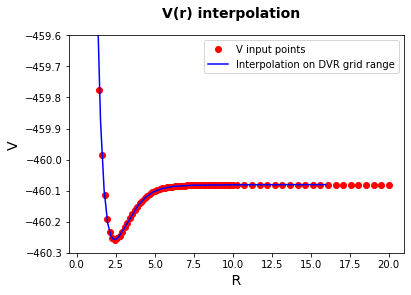

In [2]:
#============== Make Directory for Plots if it's not there already ==========
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Plot_Output = path+'/Plot_Output'
if os.path.exists(Plot_Output):
    print("Directory for wave function plots already exists",Plot_Output)
else:
    print("Attempting to create directory for wave function plots ",Plot_Output)
    try:  
        os.mkdir(Plot_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Plot_Output)
    else:  
        print ("Successfully created the directory %s " % Plot_Output)
#
#=== Make Directory for for the .dat output  if it's not there already ======
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Data_Output = path+'/Data_Output'
if os.path.exists(Data_Output):
    print("Directory for output .dat files  already exists",Plot_Output)
else:
    print("Attempting to create directory for .dat output files  ",Plot_Output)
    try:  
        os.mkdir(Data_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Data_Output)
    else:  
        print ("Successfully created the directory %s " % Data_Output)
# ===================================================================
wfcn_plotfile=open("Data_Output/wavefunctions.dat","w") # data file for saving wavefunctions
#
#=============Constants and conversion factors ==============
Daltons_to_eMass = 1822.89
bohr_to_Angstrom = 0.529177
Hartree_to_eV = 27.211386245988 # NIST ref
eV_to_wavenumber = 8065.54393734921 # NIST ref on constants + conversions 
Hartree_to_wavenumber = 2.1947463136320e5    # value from NIST ref on constants + conversions
atu_to_fs = 24.18884326509/1000
HartreeToKelvin = 315773;
#
#=====================================FEM_DVR===================================
#  Set up the FEM DVR grid given only the Finite Element boundaries and order
#  of Gauss Lobatto quadrature,  and compute the Kinetic Energy matrix for 
#  this FEM DVR for Mass = mass set in call (atomic units).
#
# Here is where the reduced mass (or mass for any 1D problem) is set 
H_Mass = 1.007825032 #H atom atomic mass
Cl_Mass = 34.968852682  # Cl 35 atomic mass
mu = (H_Mass*Cl_Mass/(H_Mass + Cl_Mass))*Daltons_to_eMass 
n_order = 40 

### this is where you change Rmax change 14 to 16

FEM_boundaries = [0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,16.0]
dvr = DVRHelper(n_order, FEM_boundaries,Mass=mu)
print("\nFEM-DVR basis of ", dvr.nbas, " functions")
#
#   Function to define potential at x and t (if potential is time-dependent)
#   DVRHelper class library expects function for V(x,t) in general
#
# =================================Potential=====================================
#  Read in file with points for potential curve in hartrees
#  and load in arrays for interpolation
#
file_name_X_state = open('HCl_CCSD_ccpvDZ.dat','r')
data = np.loadtxt(file_name_X_state)  # load a blank separated file
#  logic to load a comma separated file
# delimiter can be "," for a .csv file. If you use " " it is sensitive to number of spaces
#data = np.loadtxt(file_name_X_state, delimiter=",")
pot_len_X_state = data.shape[0]
pot_columns = data.shape[1]
print("Finished reading file with potential  with ",pot_len_X_state," rows and ",pot_columns," columns")
r_vals_X_state=np.empty(pot_len_X_state)
V_vals_X_state=np.empty(pot_len_X_state)
for i in range(0,pot_len_X_state):
    r_vals_X_state[i] = data[i,0]
    V_vals_X_state[i] = data[i,1]
#
#   Set up the CubicSpline interpolation from the scipy.interpolate library
#
Potential_interpolated = CubicSpline(r_vals_X_state,V_vals_X_state)
n_vals_pot = r_vals_X_state.shape[0]
print("interpolation parameters -- number of values and limits: ",n_vals_pot,"  ", r_vals_X_state[0],r_vals_X_state[n_vals_pot-1])
#
#  This is the potential energy function passed to DVRHelper
def V_X_state(r,time):
    #
    # Returns interpolated value of potential after checking
    # that r is in the range of the input data 
    #
    if(r >= r_vals_X_state[0] and r <= r_vals_X_state[n_vals_pot-1]):
         pot = Potential_interpolated(r)
    else:
        print("Failed in V_X_state with argument out of range of input data",r)
        exit()
#   return interpolated value
    return pot
# vectorized version of potential routine to be used in calls to Hamiltonian 
# speeds up time-dependent calculations where it is called many times
vectorized_V_X_state = np.vectorize(V_X_state)
#
#===========================================================================================
#  Plot potential on the DVR grid points on which the wavefunction is defined
#  and ALSO the interpolation to check we are using the potential that we mean to.
#
print("\n Plot potential ")
x_Plot = []
pot_Plot_red = []
for j in range(0,n_vals_pot):
    x_Plot.append(r_vals_X_state[j])
    pot_Plot_red.append( V_vals_X_state[j])
plt.suptitle('V(r) interpolation', fontsize=14, fontweight='bold')
string="V input points"
plt.plot(x_Plot,pot_Plot_red,'ro',label=string)
#
x_Plot = []
pot_Plot_blue = []
Number_plot_points = 750
dx = (dvr.x_pts[dvr.nbas-1] - dvr.x_pts[0])/float(Number_plot_points-1)
time = 0.0 # dummy time in general call to potential function
for j in range(0,Number_plot_points):
    x= dvr.x_pts[0] + j*dx
    x_Plot.append(x)
    pot_Plot_blue.append(vectorized_V_X_state(x,time))
plt.plot(x_Plot,pot_Plot_blue,'-b',label="Interpolation on DVR grid range")
plt.legend(loc="best")
plt.xlabel(" R ", fontsize=14)
plt.ylabel("V", fontsize=14)
print("\n Running from terminal, close figure window to proceed and make .pdf file of figure")
#   Insert limits if necessary
#xmax = float(rmax)  # CWM: need to use float() to get plt.xlim to work to set x limits
plt.ylim([-460.3,-459.6])
#number_string = str(a)
plt.savefig('Plot_Output/' + 'Plot_potential' + '.pdf', transparent=False)
plt.show()

In [3]:
#
# 
# =============Build Hamiltonian (using general routine with dummy time t=0)=========
#     Pass name of potential function explicitly here
time = 0.0
H_mat = dvr.Hamiltonian(vectorized_V_X_state, time)
print("\n Completed construction of Hamiltonian ")
#====================================================================================
#
# Find all the eigenvalues of the Hamiltonian so we can compare with known bound state energies
# or make a plot of the spectrum -- For a time-independent Hamiltonian example here
#
EigenVals = LA.eigvalsh(H_mat)
#
n_energy = 80  # number of energies to print, also number of eigenvectors to compute below
#======================================================================================
#  A good place to compute the density of states at each of these eigenvalues (except 
#  the lowest one, EigenVals[0], were the formula for the derivative, 
#  (EigenVals[i+1]-Eigenvals[i-1])/2.0 doesn't apply of course.   is HERE
#                       *****************************
# =========================Print the calculated Energies ==================================
for  i in range(0,n_energy):
        print("E( ",i,") =   ",EigenVals[i]," hartrees, excitation energy = ",(EigenVals[i]-EigenVals[0])*Hartree_to_eV*eV_to_wavenumber," cm^-1")
#=======================================================================================
#  A good place to Plot Density of states required in the problem is HERE  
#                     **************************
# ====================================================================================
#
# Extract the n_Plot'th eigenfunction for plotting and use as initial wave function
# to test propagation
#
number_of_eigenvectors = n_energy # calculate this number of eigenvectors. Calculating
                                  # them all is slow for large grids
#
#  Here we set a value of n_Plot that is the index of  which eigenfunction to plot
#  and use in the V_ni = <n|V|i> matrix element.
#  To do that we find  the eigenvalue nearest to the value of Efinal chosen below
#


 Completed construction of Hamiltonian 
E(  0 ) =    -460.25085232854485  hartrees, excitation energy =  0.0  cm^-1
E(  1 ) =    -460.23750288240706  hartrees, excitation energy =  2929.864769995397  cm^-1
E(  2 ) =    -460.22464599523306  hartrees, excitation energy =  5751.625342986331  cm^-1
E(  3 ) =    -460.21227937354246  hartrees, excitation energy =  8465.785079739551  cm^-1
E(  4 ) =    -460.20040227230265  hartrees, excitation energy =  11072.507496008946  cm^-1
E(  5 ) =    -460.18901573339974  hartrees, excitation energy =  13571.563924228145  cm^-1
E(  6 ) =    -460.17812280702094  hartrees, excitation energy =  15962.284925682006  cm^-1
E(  7 ) =    -460.1677285170954  hartrees, excitation energy =  18243.567875375844  cm^-1
E(  8 ) =    -460.15783954262923  hartrees, excitation energy =  20413.946900894294  cm^-1
E(  9 ) =    -460.14846453887935  hartrees, excitation energy =  22471.522392927956  cm^-1
E(  10 ) =    -460.1396146013506  hartrees, excitation energy =  244

Final state:  42    -460.0702990964613   DOS(Efinal)  1077.5646302047073
Calculating  80  eigenvectors for plotting eigenfunctions
Norm of wave function being plotted is  0.9999999999999998

 Plot wave function  42  (numbered in order of increasing energy)

 Running from terminal, close figure window to proceed and make .pdf file of figure


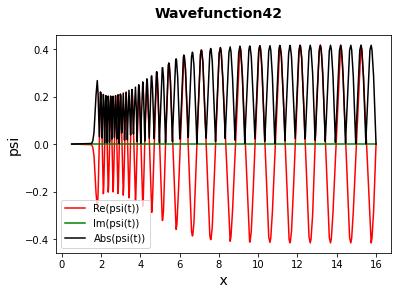

In [4]:
jfinal = 0
Efinal = -460.07  # nearest eigenvalue to this value will be picked
deltaE_old = 100.0
for i in range(0,n_energy):
    deltaE_new = Efinal - EigenVals[i]
    if np.abs(deltaE_new) < np.abs(deltaE_old):
       deltaE_old = deltaE_new
       jfinal = i
deriv = (-EigenVals[jfinal - 1] + EigenVals[jfinal + 1])/2.0
Efinal = EigenVals[jfinal]
DOS_Efinal = 1.0/deriv 
print("Final state: ",jfinal,"  ",Efinal,"  DOS(Efinal) ",DOS_Efinal)
n_Plot = jfinal  # pick a state of this potential to plot < number_of_eigenvectors -1
#
#  calculate the eigenvectors of the Hamiltonian
#
print("Calculating ",number_of_eigenvectors," eigenvectors for plotting eigenfunctions")
EigenVals, EigenVecs  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors))
wfcnPlot = []
for j in range(0,dvr.nbas):
    wfcnPlot.append(EigenVecs[j,n_Plot])
#
# normalize  the wave function from the diagonalization of the Hamiltonian
#
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
wfcnPlot = wfcnPlot/np.sqrt(norm_squared)
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
print("Norm of wave function being plotted is ", np.sqrt(norm_squared))
#
#================# Plot the  wave function specified by n_Plot above======================
#   It must be type complex for the general wave function plotting logic
#   in the plotting routine dvr.Plot_Psi() to work correctly
#
int_value = 0.
#
Cinitial  = np.zeros((dvr.nbas), dtype=complex) 
wfcnInitialPlot  = np.zeros((dvr.nbas), dtype=complex) 
for j in range(0,dvr.nbas):
   Cinitial[j] = wfcnPlot[j]
#
print("\n Plot wave function ",n_Plot," (numbered in order of increasing energy)")
title = 'Wavefunction'+str(n_Plot)
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Cinitial, plot_title_string=title,N_plot_points=Number_plot_points,make_plot=True)
# write the data in file also
for j in range(0,Number_plot_points):
    print(x_Plot_array[j],"  ",np.real(Psi_plot_array[j]),"  ",np.imag(Psi_plot_array[j]),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#
# plot square of wave function (radial probability distribution)
#


 Average value of r using DVR for the integral, <r> =  (10.022496507333562+0j)

 Running from terminal, close figure window to proceed and make .pdf file of figure


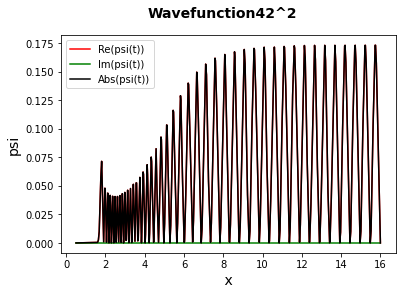

value of integral <n|V|i> =   4.005618015779955e-05


In [5]:
Csquared=np.zeros(dvr.nbas,dtype=complex)
raverage = 0.0
for i in range(dvr.nbas):
#  make an array representing the square of the wave function to trick routine dvr.Plot_Psi()
#  into plotting the square of the wave function.  Note that at low orders this interpolation
#  can be less accurate than the representation of the wave function itself.
   Csquared[i] = np.abs(Cinitial[i])**2 / np.sqrt(dvr.w_pts[i+1])
#   compute <r> for this wave function
#   note that Cinitial[i] contains the necessary weight, sqrt(dvr.w_pts[i+1])
   raverage = raverage +Cinitial[i]**2 *dvr.x_pts[i+1]
print("\n Average value of r using DVR for the integral, <r> = ",raverage)
title = 'Wavefunction'+str(n_Plot)+"^2"
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Csquared, plot_title_string=title,N_plot_points=Number_plot_points,make_plot=True)
# write the data in file also
for j in range(0,Number_plot_points):
    print(x_Plot_array[j],"  ",np.real(Psi_plot_array[j]),"  ",np.imag(Psi_plot_array[j]),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
# ====================================================================================
#
#  Calculate a bound-free matrix element, Vni, using the final state function 
#  chosen above
#
# ====================================================================================
def phi_initial(x):
   alpha = 12 
   fval = np.exp(-alpha*(x-2.45)**2)*(2.0*alpha/np.pi)**0.25
   return fval
def V_pert(x):
   dipole_op = (x-2.45)
   return dipole_op
#
for j in range(0,dvr.nbas):
    int_value = int_value + wfcnPlot[j]*phi_initial(dvr.x_pts[j+1])*V_pert(dvr.x_pts[j+1])*np.sqrt(dvr.w_pts[j+1])    
Vni = int_value
print("value of integral <n|V|i> =  ",Vni)
#======================================================================================
#  HERE would be a good place to
#  Evaluate Fermi Golden Rule rate using Vni and density of states 
#======================================================================================

#exit()

In [6]:
# Graphs

In [7]:
# This is for when R max = 14
EigenVals14 = np.array([-460.25085233, -460.23750288, -460.224646  , -460.21227937,
       -460.20040227, -460.18901573, -460.17812281, -460.16772852,
       -460.15783954, -460.14846454, -460.1396146 , -460.13130266,
       -460.1235434 , -460.11635444, -460.10975699, -460.10377602,
       -460.09844039, -460.09378228, -460.08983474, -460.08662603,
       -460.08416918, -460.0824455 , -460.08138273, -460.08084809,
       -460.08060528, -460.08032384, -460.0799495 , -460.07949526,
       -460.07896888, -460.07837548, -460.07771876, -460.07700158,
       -460.07622625, -460.0753947 , -460.07450854, -460.0735692 ,
       -460.07257792, -460.07153578, -460.07044378, -460.06930281,
       -460.06811367, -460.06687712, -460.06559382, -460.06426441,
       -460.06288947, -460.06146955, -460.06000515, -460.05849674,
       -460.05694477, -460.05534966, -460.05371181, -460.05203159,
       -460.05030935, -460.04854543, -460.04674014, -460.0448938 ,
       -460.04300669, -460.04107908, -460.03911124, -460.03710342,
       -460.03505586, -460.03296879, -460.03084243, -460.028677  ,
       -460.0264727 , -460.02422972, -460.02194826, -460.01962849,
       -460.01727059, -460.01487474, -460.01244109, -460.00996981,
       -460.00746104, -460.00491493, -460.00233164, -459.99971129,
       -459.99705402, -459.99435996, -459.99162924, -459.98886198,
       -459.9860583 ])


In [8]:
# This is the derivative when Rmax = 14
Derivative14 = []
for i in np.arange(1,80): 
    Derivative14.append(2/(EigenVals14[i+1]-EigenVals14[i-1]))

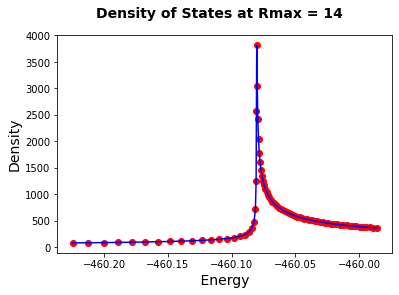

In [9]:
# the peak is in the right place but the first point looks off
plt.plot(EigenVals14[2:len(EigenVals14)],Derivative14, color = "blue")
plt.scatter(EigenVals14[2:len(EigenVals14)],Derivative14, color="red")
plt.suptitle('Density of States at Rmax = 14', fontsize=14, fontweight='bold')
plt.xlabel(" Energy ", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

In [10]:
#this is the rate when Rmax = 14
Vni14 = 4.4092441487393516e-05
h=1
rate14 = []
for i in np.arange(0,80):
    FGR_rate = ((np.pi*2/h))* (Vni14**2) * 895.668
    rate14.append(FGR_rate)

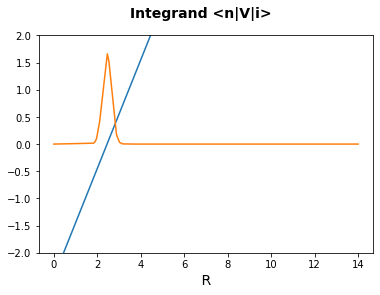

In [11]:
# Bottom Right: The two other factors in Vni = <n|V|i>,
# namely the perturbation potential (proportional to dipole moment as function of R)
# and the initial wave function |ii.
#
#
R_values = np.linspace(0,14,200)
phi = []
for i in R_values: 
    phi.append(phi_initial(i))
pert = []
for i in R_values: 
    pert.append(V_pert(i))
plt.plot(R_values,pert)
plt.plot(R_values,phi)
plt.ylim([-2,2])
plt.suptitle('Integrand <n|V|i>', fontsize=14, fontweight='bold')
plt.xlabel(" R ", fontsize=14)
plt.show()

In [12]:
# This is for when R max = 16
EigenVals16 = np.array([-460.25085233, -460.23750288, -460.224646  , -460.21227937,
       -460.20040227, -460.18901573, -460.17812281, -460.16772852,
       -460.15783954, -460.14846454, -460.1396146 , -460.13130266,
       -460.1235434 , -460.11635444, -460.10975699, -460.10377602,
       -460.09844039, -460.09378228, -460.08983474, -460.08662603,
       -460.08416918, -460.0824455 , -460.08138273, -460.08084891,
       -460.08064644, -460.08047738, -460.08024419, -460.07995179,
       -460.07960609, -460.07921087, -460.0787688 , -460.07828194,
       -460.0777519 , -460.07718002, -460.07656746, -460.07591518,
       -460.07522404, -460.07449481, -460.07372818, -460.07292475,
       -460.07208509, -460.07120971, -460.0702991 , -460.06935368,
       -460.06837386, -460.06736002, -460.06631253, -460.0652317 ,
       -460.06411786, -460.0629713 , -460.0617923 , -460.06058112,
       -460.05933801, -460.05806321, -460.05675696, -460.05541945,
       -460.05405091, -460.05265153, -460.05122149, -460.04976098,
       -460.04827018, -460.04674924, -460.04519832, -460.04361759,
       -460.04200719, -460.04036726, -460.03869794, -460.03699936,
       -460.03527165, -460.03351494, -460.03172934, -460.02991496,
       -460.02807193, -460.02620035, -460.02430032, -460.02237195,
       -460.02041533, -460.01843054, -460.01641771, -460.014377  ,
       -460.01230855])

In [13]:
# This is the derivative when Rmax = 16
Derivative16 = []
for i in np.arange(1,80): 
    Derivative16.append(2/(EigenVals16[i+1]-EigenVals16[i-1]))

In [14]:
#this is the rate when Rmax = 16
Vni16 = 4.005618015779955e-05
h=1
rate16 = []
for i in np.arange(0,80):
    FGR_rate = ((np.pi*2/h)) * (Vni16**2) * 1077.57
    rate16.append(FGR_rate)

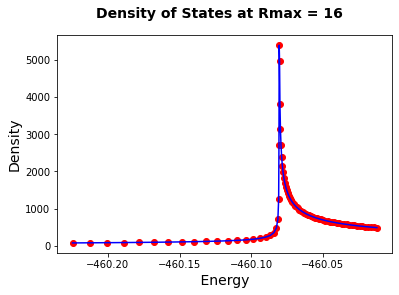

In [15]:
#
plt.plot(EigenVals16[2:len(EigenVals16)],Derivative16, color = "blue")
plt.scatter(EigenVals16[2:len(EigenVals16)],Derivative16, color="red")
plt.suptitle('Density of States at Rmax = 16', fontsize=14, fontweight='bold')
plt.xlabel(" Energy ", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

In [16]:
# This is for when Rmax = 18
EigenVals18 = np.array([-460.25085233, -460.23750288, -460.224646  , -460.21227937,
       -460.20040227, -460.18901573, -460.17812281, -460.16772852,
       -460.15783954, -460.14846454, -460.1396146 , -460.13130266,
       -460.1235434 , -460.11635444, -460.10975699, -460.10377602,
       -460.09844039, -460.09378228, -460.08983474, -460.08662603,
       -460.08416918, -460.0824455 , -460.08138273, -460.08084894,
       -460.08065559, -460.08053879, -460.0803847 , -460.08018541,
       -460.07994532, -460.07966742, -460.07935373, -460.07900579,
       -460.07862477, -460.07821167, -460.07776731, -460.07729239,
       -460.07678753, -460.07625328, -460.07569013, -460.07509853,
       -460.07447886, -460.07383151, -460.07315681, -460.07245508,
       -460.07172661, -460.07097167, -460.07019051, -460.06938338,
       -460.0685505 , -460.06769209, -460.06680834, -460.06589945,
       -460.06496561, -460.06400697, -460.06302371, -460.06201599,
       -460.06098396, -460.05992775, -460.05884751, -460.05774337,
       -460.05661546, -460.0554639 , -460.0542888 , -460.05309027,
       -460.05186844, -460.05062352, -460.04935558, -460.04806399,
       -460.04674826, -460.0454124 , -460.0440635 , -460.04268973,
       -460.04125649, -460.03977616, -460.03840269, -460.03716522,
       -460.03562701, -460.03381742, -460.03188537, -460.03053006,
       -460.02968714])

In [17]:
# This is the derivative when Rmax = 18
Derivative18 = []
for i in np.arange(1,80): 
    Derivative18.append(2/(EigenVals18[i+1]-EigenVals18[i-1]))

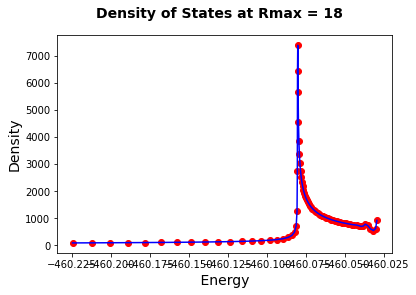

In [24]:

plt.plot(EigenVals18[2:len(EigenVals18)],Derivative18, color = "blue")
plt.scatter(EigenVals18[2:len(EigenVals18)],Derivative18, color="red")
plt.suptitle('Density of States at Rmax = 18', fontsize=14, fontweight='bold')
plt.xlabel(" Energy ", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

In [19]:
#this is the rate when Rmax = 18
Vni18 = 3.695580101987641e-05
h=1
rate18 = []
for i in np.arange(0,80):
    FGR_rate = (np.pi*2/h)* Vni18**2 * 1259.22
    rate18.append(FGR_rate)

In [20]:

Table().with_columns("Wni14",np.array(rate14),"Wni16",np.array(rate16),"Wni18",np.array(rate18)).show(1)

Wni14,Wni16,Wni18
1.0941e-05,1.08634e-05,1.08055e-05


In [21]:
#list of all Vni
Table().with_columns("Vni14",Vni14,"Vni16",Vni16,"Vni18",Vni18)

Vni14,Vni16,Vni18
4.40924e-05,4.00562e-05,3.69558e-05


In [22]:
# List of all densities
Table().with_columns("Density14",Derivative14,"Density16",Derivative16,"Density18",Derivative18).show(4)

Density14,Density16,Density18
76.3174,76.3174,76.3174
79.2911,79.2911,79.2911
82.4956,82.4956,82.4956
85.9711,85.9711,85.9711
